In [1]:
import torch
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import binary_erosion
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
import pandas as pd
from torchvision import datasets
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler


In [2]:
#images = "/home/bandyadkas/cellcyle/data/"
images = "/mnt/efs/woods_hole/bbbc_cellcycle/model_data/data/"

In [3]:
transform = {
        'train': transforms.Compose([
            transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomRotation(45),
            transforms.RandomResizedCrop((224,224), scale=(0.08, 1.0))
            #transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize([224,224]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            #transforms.Normalize(mean=(0), std=(1))
        ])
    }

In [4]:
all_images = datasets.ImageFolder(images,transform=transform['train'])
print(len(all_images))

32266


In [5]:
train_size = int(0.7 * len(all_images))
val_size = int(0.15 * len(all_images))
test_size = len(all_images) - (train_size + val_size)
print(train_size, val_size, test_size)
assert train_size + val_size + test_size == len(all_images)

22586 4839 4841


In [6]:
train_set, val_set, test_set = torch.utils.data.random_split(all_images, [train_size, val_size, test_size])
#train_set, val_set, test_set = torch.utils.data.random_split(all_images, [22538, 4829, 4831])

In [7]:
def _get_weights(subset,full_dataset):
    ys = np.array([y for _, y in subset])
    counts = np.bincount(ys)
    label_weights = 1.0 / counts
    weights = label_weights[ys]

    print("Number of images per class:")
    for c, n, w in zip(full_dataset.classes, counts, label_weights):
        print(f"\t{c}:\tn={n}\tweight={w}")
        
    return weights


Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


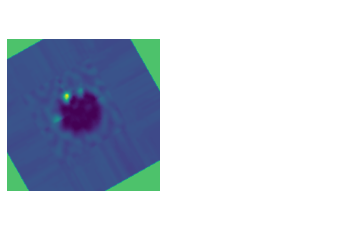

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


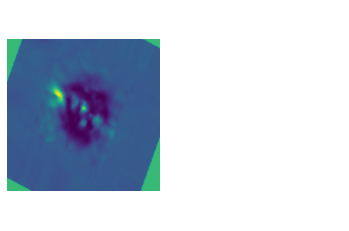

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


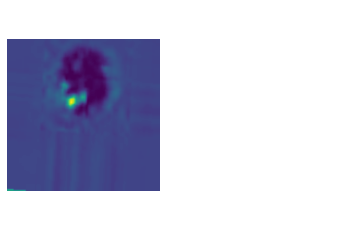

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


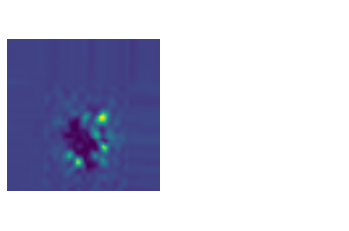

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


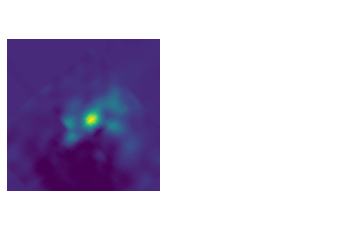

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


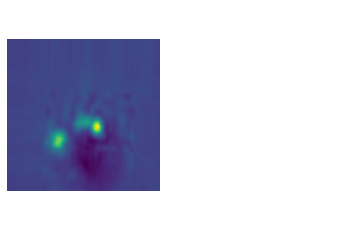

In [8]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0])                     # show the image
    #axarr[1].imshow(mask[0])                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    print(img.shape)
    plt.show()

show_random_dataset_image(train_set)
show_random_dataset_image(train_set)
show_random_dataset_image(train_set)
show_random_dataset_image(train_set)


show_random_dataset_image(val_set)
show_random_dataset_image(test_set)

In [9]:

train_weights = _get_weights(train_set,all_images)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))


Number of images per class:
	Anaphase:	n=9	weight=0.1111111111111111
	G1:	n=10062	weight=9.938382031405287e-05
	G2:	n=6017	weight=0.00016619577862722287
	Metaphase:	n=47	weight=0.02127659574468085
	Prophase:	n=421	weight=0.0023752969121140144
	S:	n=6009	weight=0.00016641704110500916
	Telophase:	n=21	weight=0.047619047619047616


In [10]:
train_loader = DataLoader(train_set, batch_size=8, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=8 , drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, drop_last=True, shuffle=True)

In [11]:
## Set up tensorboard
writer = SummaryWriter('/home/healeyh/cellcycle/runs/hmh_cellcycle_exp1/cellcycle_resnet18_augmentations')

In [12]:
#!tensorboard --logdir=runs

In [13]:
resnet18_model = torchvision.models.resnet18(pretrained = False, progress  = True, num_classes=7)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18_model.parameters(), lr=0.001)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18_model.to(device)
print(f"Will use device {device} for training")

Will use device cuda for training


In [15]:
from tqdm import tqdm

def train(model,loss,train_dataloader):
    model.train()
    epoch_loss = 0
    num_batches = 0
    for x, y in tqdm(train_dataloader):

        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        y_pred = model(x)
        l = loss(y_pred, y)
        l.backward()
        optimizer.step()

        epoch_loss += l
        num_batches += 1

    return epoch_loss/num_batches

def evaluate(model, loss, dataloader):
    
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in tqdm(dataloader):

            x, y = x.to(device), y.to(device)

            logits = model(x)
            val_loss = loss(logits,y)
            
            probs = torch.nn.Softmax(dim=1)(logits)
            predictions = torch.argmax(probs, dim=1)

            correct += int(torch.sum(predictions == y).cpu().detach().numpy())
            total += len(y)

        accuracy = correct/total

    return accuracy, val_loss

def validate(model,loss, validation_dataloader):
    '''Evaluate prediction accuracy on the validation dataset.'''
    
    model.eval()
    return evaluate(model,loss,validation_dataloader)

def test(model,loss,test_dataloader):
    '''Evaluate prediction accuracy on the test dataset.'''
    
    model.eval() 
    return evaluate(model, loss,test_dataloader)

In [ ]:
step = 0
epochs = 130
for epoch in range(epochs+1):
    while step < epoch: 
    
        epoch_loss = train(resnet18_model,loss_fn,train_loader)
        print(f"epoch {epoch}, training loss={epoch_loss}")
    
        validation_accuracy, validation_loss = validate(resnet18_model, loss_fn,val_loader)
        print(f"epoch {epoch}, validation accuracy={validation_accuracy}")
    
        writer.add_scalar('Loss/train', epoch_loss.cpu().detach().numpy(),step)      
        writer.add_scalar('Accuracy/validation', validation_accuracy,step)
        writer.add_scalar('Loss/validation', validation_loss.cpu().detach().numpy(),step)
        
        if step == 150:
            state = {
                'epoch': epoch,
                'state_dict': resnet18_model.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            torch.save(state, "/mnt/efs/woods_hole/bbbc_cellcycle/classify_cellCycle_bandyadka/modelsave_resnet18.pth")
        
        step += 1

In [ ]:
#load_model = torch.load("/mnt/efs/woods_hole/bbbc_cellcycle/classify_cellCycle_bandyadka/modelsave.pth")

In [20]:
test_accuracy, test_loss = test(resnet18_model,loss_fn,test_loader)
print(f"final test accuracy: {test_accuracy}")
writer.add_scalar('Accuracy/test', test_accuracy)
writer.add_scalar('Loss/test', test_loss.cpu().detach().numpy(),step)
        


100%|███████████████████████████████████████████████████████████████████████████████████████████| 605/605 [00:37<00:00, 16.07it/s]

final test accuracy: 0.7206611570247934


In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# predict the test dataset
def predict(model, dataset):
    dataset_prediction = []
    dataset_groundtruth = []
    model = model.cuda()
    with torch.no_grad():
        for x, y_true in dataset:
            inp = x[None].cuda()
            y_pred = model(inp)
            dataset_prediction.append(y_pred.argmax().cpu().numpy())
            dataset_groundtruth.append(y_true)
    
    return np.array(dataset_prediction), np.array(dataset_groundtruth)
            
    # create seabvorn heatmap with required labels
    #sns.heatmap(flights_df, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax.set_title(title)



In [39]:
import pandas as pd
# Plot confusion matrix 
# orginally from Runqi Yang; 
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, title, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels = ["0", "1", "2", "3", "4", "5", "6"]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    x_axis_labels = ['Anaphase', 'G1', 'G2', 'Metaphase', 'Prophase', 'S', 'Telophase'] # labels for x-axis
    y_axis_labels = ['Anaphase', 'G1', 'G2', 'Metaphase', 'Prophase', 'S', 'Telophase'] # labels for y-axis
# create seabvorn heatmap with required labels
    #sns.heatmap(flights_df, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap = "viridis")
    ax.set_title(title)

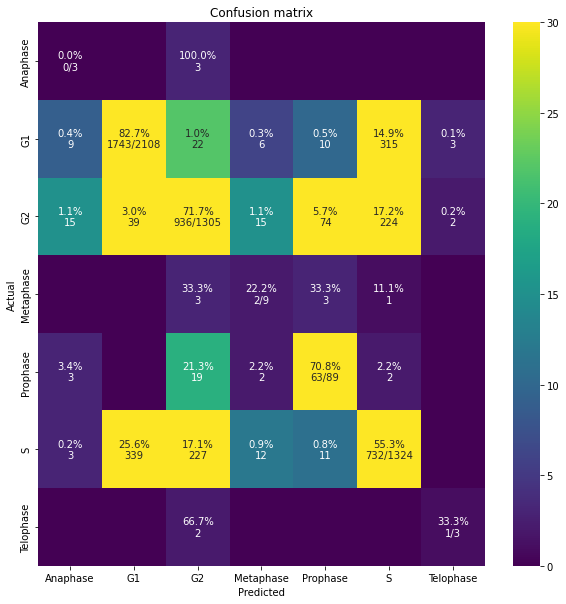

In [40]:
y_pred, y_true = predict(resnet18_model, test_set)
cm_analysis(y_true, y_pred, "Confusion matrix")

## Integrated Gradients Exploration

In [28]:
from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
import numpy as np

test_pred, test_true = predict(resnet18_model.cuda(), test_set)


def visualize_ig(idx, 
                 _train_dataset=train_set, 
                 _test_dataset=test_set):
    
    #test_pred, test_true = predict1(resnet18.cuda(), _test_dataset[idx])
    
    # Get corresponding input and target tensors:
    input_tensor = _test_dataset[idx][0].unsqueeze(0)
    input_tensor.requires_grad = True
    target = _test_dataset[idx][1]
    
    # We will use the IntegratedGradients algorithm:
    algorithm = IntegratedGradients(resnet18_model.cpu())
    
    # First we clear the gradients from the model:
    resnet18_model.zero_grad()
    
    # Run attribution:
    attr_ig, delta = algorithm.attribute(input_tensor,
                                          target=target,
                                          baselines=input_tensor * 0,
                                          return_convergence_delta=True
                                        )
    
    # Integrated Gradients:
    attr_ig = np.transpose(attr_ig[0].cpu().detach().numpy(), (1, 2, 0))
    
    # Original image:
    original_image = np.transpose((_test_dataset[idx][0].detach().numpy() * 0.5) + 0.5, (1, 2, 0))
    
    #print("Annotated Stage", _test_dataset[idx][1])
    print("Annotated Stage", test_true[idx])
    plt.imshow(original_image)
    
    
    print("Predicted Stage", test_pred[idx])


    # This visualises the attribution of labels to 
    viz.visualize_image_attr(attr_ig, 
                             original_image, 
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True, 
                             title="Overlayed Integrated Gradients")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotated Stage 2
Predicted Stage 2


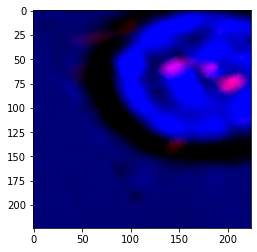

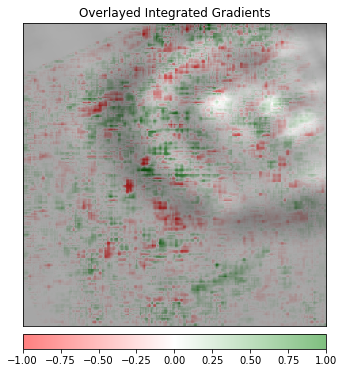

In [29]:
visualize_ig(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotated Stage 5
Predicted Stage 5


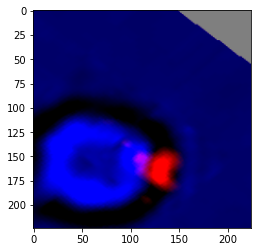

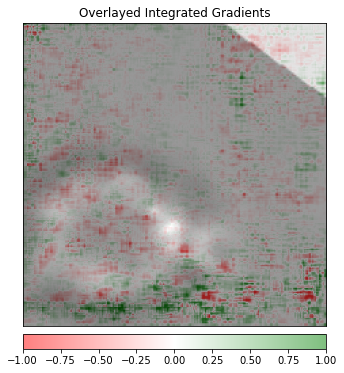

In [30]:
visualize_ig(8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotated Stage 5
Predicted Stage 5


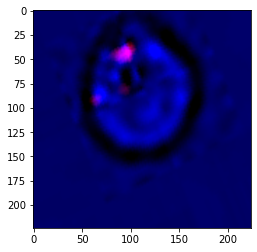

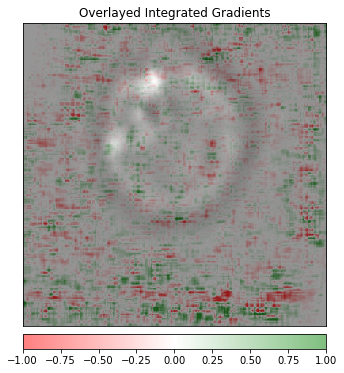

In [31]:
visualize_ig(20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Annotated Stage 2
Predicted Stage 2


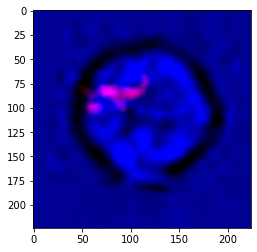

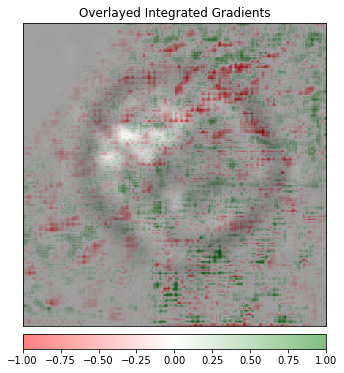

In [32]:
visualize_ig(390)

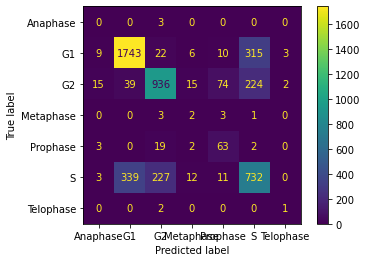

In [41]:
import sklearn
confusion = sklearn.metrics.confusion_matrix(y_true, y_pred)

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=all_images.classes)
disp.plot()
plt.show()

## more training

In [ ]:
resnet18_aug_model_more = copy.deepcopy